In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
import copy
%matplotlib inline
import os
import glob

## First download the preprocessed H3.6m Dataset

The dataset is downloaded to [data/h3.6m](data/h3.6m).

In [2]:
if not os.path.exists('data'):
    os.mkdir('data')
os.chdir('data')
os.system('svn checkout https://github.com/BII-wushuang/Lie-Group-Motion-Prediction/trunk/src/data/h3.6m/')
os.chdir('../')

## Preliminaries

Below we define a class for a skeleton. It will be initialized with the skeletal offsets as well as a kinematic tree (the different kinematic chains in the skeleton).

The base skeletal offsets characterizes the default human pose, with no rotations at any joint.

In [3]:
class Skeleton:
    def __init__(self, kinematic_tree):
        # We first define the skeleton for H3.6m
        self._kinematic_tree = kinematic_tree
       
    def kinematic_tree(self):
        return self._kinematic_tree

    def plot(self, joints):
        plt.figure()
        limits = 1200
        ax = plt.axes(xlim=(-limits,limits), ylim=(-limits,limits), zlim=(-limits,limits), projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(elev=120, azim=-90)
        ax.scatter(joints[:,0], joints[:,1], joints[:,2], color='black')
        colors = ['red', 'yellow', 'black', 'green', 'blue']
        for chain, color in zip(self._kinematic_tree, colors):
            ax.plot3D(joints[chain,0], joints[chain,1], joints[chain,2], linewidth=2.0, color=color)


## Initialze Skeleton class with following parameters

In [4]:
# Define a kinematic tree for the skeletal struture
# Left leg, Right leg, Spine, Left arm, Right arm
kinematic_tree = [[0, 1, 2, 3, 4, 5], [0, 6, 7 ,8, 9, 10], [0, 12, 13, 14, 15], [13, 17, 18, 19, 22, 19, 21], [13, 25, 26, 27, 30, 27, 29]]
human_skel = Skeleton(kinematic_tree)
njoints = 32
parents = np.array([-1,  0,  1,  2,  3,  4,  0,  6,  7,  8,  9,  0, 11, 12, 13, 14, 12, 16, 17, 18, 19, 20, 19, 22, 12, 24, 25, 26, 27, 28, 27, 30])

## Load a sample 3D pose and plot

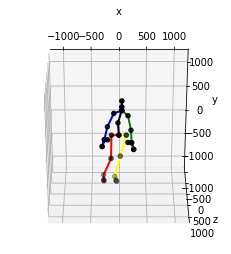

In [5]:
data = sio.loadmat('Data/h3.6m/Train/train_xyz/S1_directions_1_xyz.mat')['joint_xyz']
nframes = len(data)
cur_frame = 0
# load the frames and switch the y and z axis
cur_joints_xyz = np.reshape(data[cur_frame], [32,3])[:,[0,2,1]]
human_skel.plot(cur_joints_xyz)

## Computing the angular velocity $\omega$ and angular acceleration $\alpha$

When computing the angular velocity of a joint, we take the origin/pivot to be its parent joint.

Let the position of joint i with respect to its parent joint in the $j-th$ frame be $\mathbf{u}[j][i]$.

To first order approximation, we have

$\frac{d\mathbf{u}[i]}{dt}\approx \mathbf{u}[j+1][i] - \mathbf{u}[j][i]\approx \omega[i]\times \mathbf{u}[j][i]$.

To second order approximation, we have

$\alpha[j][i] \approx \omega[j+1][i] - \omega[j][i]$,

$\frac{d^2\mathbf{u}[i]}{dt^2}\approx \mathbf{u}[j+2][i] - 2\mathbf{u}[j+1][i] + \mathbf{u}[j][i]\approx \alpha[j][i]\times\mathbf{u}[j][i] + \omega[j][i]\times(\omega[j][i]\times \mathbf{u}[j][i])$.

In [6]:
def findrot(u, v):
    '''find the axis angle parameters to rotate vector u onto vector v'''
    u = u/np.linalg.norm(u)
    v = v/np.linalg.norm(v)
    w = np.cross(u, v)
    w_norm = np.linalg.norm(w)
    if w_norm < 1e-6:
        A = np.zeros(3)
    else:
        A = w / w_norm * np.arccos(np.dot(u, v))
    return A

u = np.zeros([nframes,njoints,3])

omega = np.zeros([nframes-1,njoints,3])
alpha = np.zeros([nframes-2,njoints,3])

for j in range(nframes):
    for i in range(1, njoints):
        joints = np.reshape(data[j], [32,3])[:,[0,2,1]]
        u[j][i] = joints[i] - joints[parents[i]]

for j in range(nframes-1):
    for i in range(1, njoints):
        if np.linalg.norm(u[j][i]) > 0:
            omega[j][i] = findrot(u[j][i],u[j+1][i])
    if j>0:
        alpha[j-1] = omega[j] - omega[j-1]

## Sanity Check for angular velocity

We can check if 
$\frac{d\mathbf{u}[i]}{dt}\approx \mathbf{u}[j+1][i] - \mathbf{u}[j][i]\approx \omega[i]\times \mathbf{u}[j][i]$.

## Sanity Check for angular acceleration

We can check if
$\frac{d^2\mathbf{u}[i]}{dt^2}\approx \mathbf{u}[j+2][i] - 2\mathbf{u}[j+1][i] + \mathbf{u}[j][i]\approx \alpha[j][i]\times\mathbf{u}[j][i] + \omega[j][i]\times(\omega[j][i]\times \mathbf{u}[j][i])$.

In [7]:
j = 15
i = 7

print(u[j+1][i] - u[j][i], '\n', np.cross(omega[j][i],u[j][i]))

print(u[j+2][i]-2*u[j+1][i] + u[j][i], '\n', np.cross(alpha[j][i],u[j][i])+np.cross(omega[j][i],np.cross(omega[j][i],u[j][i])))

[ 7.67852253 -0.27187875  2.06223339] 
 [ 7.67354744 -0.34266839  2.07059982]
[0.71737025 0.1237449  0.06764268] 
 [0.71834762 0.09792262 0.07144112]
